In [175]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
from heapq import nlargest
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dense, Bidirectional, LSTM, Dropout, Input, Flatten
from keras.initializers import Constant
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.set()

In [61]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [62]:
df.shape

(2225, 2)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [64]:
df.apply(pd.isnull).sum()

category    0
text        0
dtype: int64

In [65]:
df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [66]:
data = df.copy()

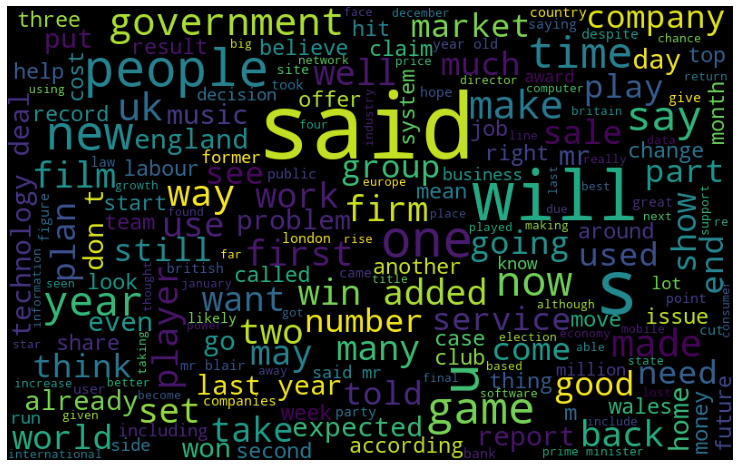

In [67]:
plt.figure(figsize = (13, 9))
all_sen = ' '.join([sentence for sentence in data['text']])
wordcloud_all = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sen)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

In [68]:
def word_cloud(category):
    plt.figure(figsize = (13, 9))
    s = ' '.join([sentence for sentence in data['text'][data['category'] == category]])
    word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(s)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(category)
    plt.show()

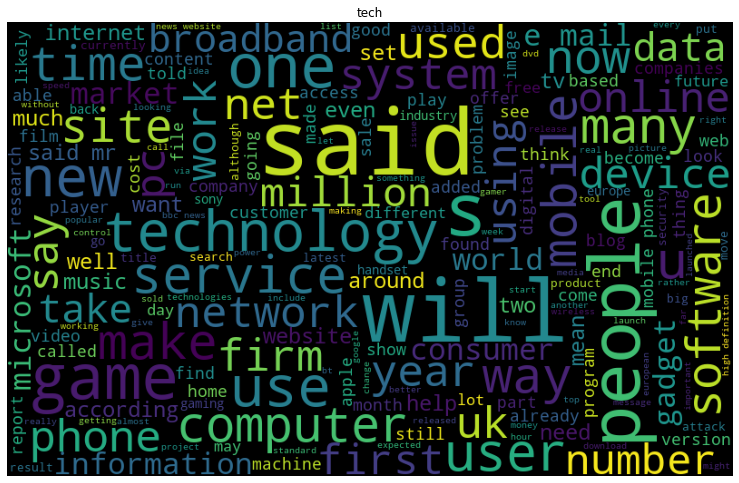

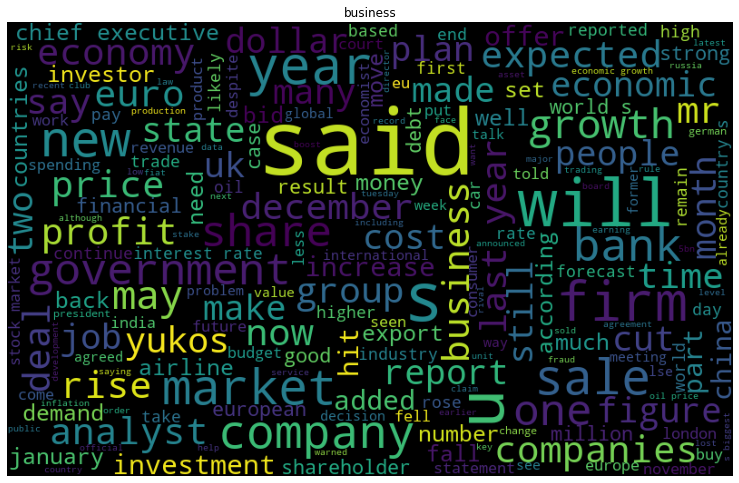

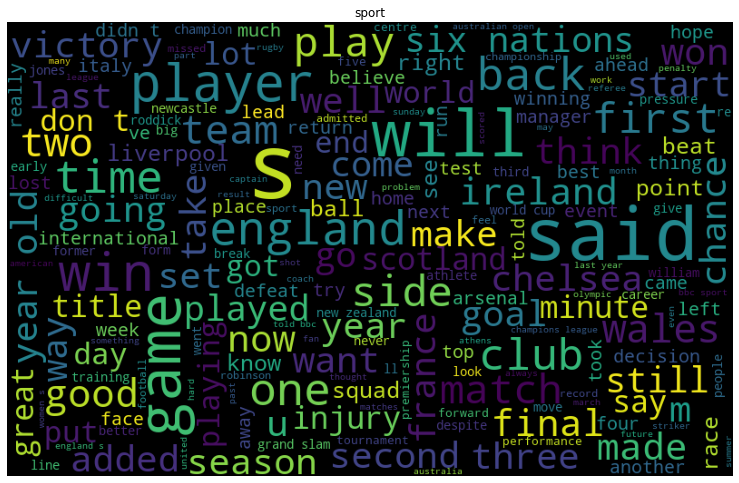

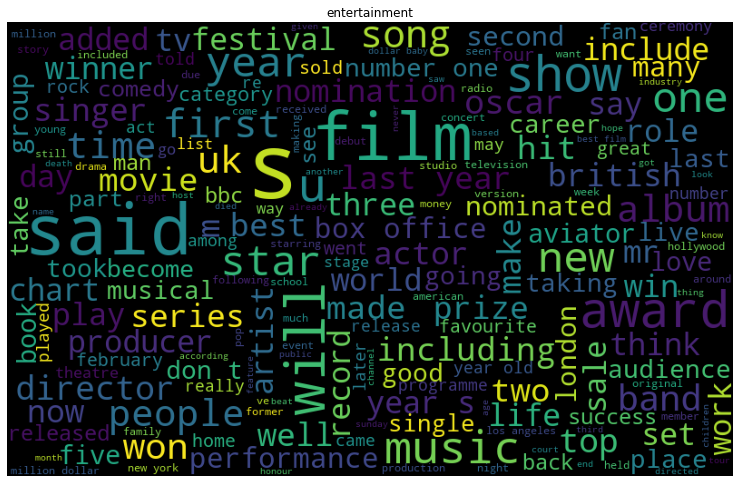

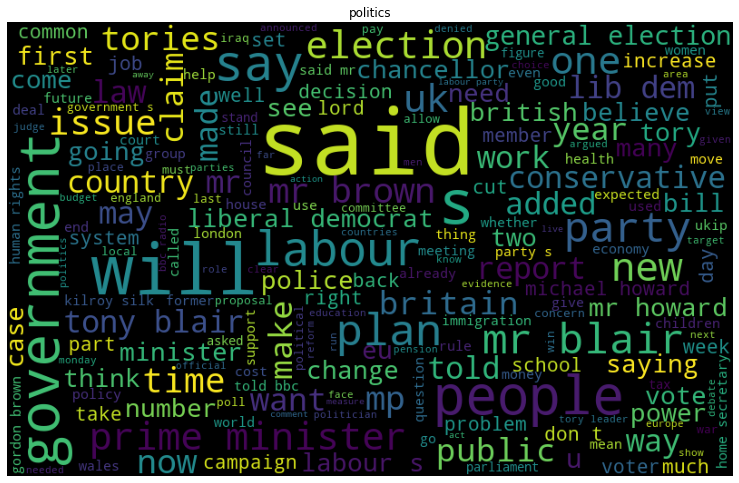

In [69]:
for i in data['category'].unique():
    word_cloud(i)

In [70]:
data['text'][10]

'berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival.  sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl  21  was arrested and beheaded with her brother  hans  in 1943 for distributing leaflets condemning the  abhorrent tyranny  of adolf hitler. director marc rothemund said:  i have a feeling of responsibility to keep the legacy of the scholls going.   we must somehow keep their ideas alive   he added.  the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund  who worked closely with surviving relatives  including one of scholl s sisters  to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 19

In [71]:
sw = stopwords.words('english')

In [72]:
lemmatizer = WordNetLemmatizer()

In [73]:
nlp = spacy.load('en_core_web_sm')

In [74]:
def text_summarization(text, num_sentences):
    doc = nlp(text)
    text = text.lower()
    text = re.sub('[^a-z.]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    word_freq = Counter(words)
    word_freq_max = max(word_freq.values())
    for word, freq in word_freq.items():
        word_freq[word] = freq / word_freq_max
    sen_score = dict()
    sentences = [sent.text for sent in doc.sents]
    for sentence in sentences:
        for word in sentence.split():
            if word in word_freq.keys():
                if sentence not in sen_score.keys():
                    sen_score[sentence] = word_freq[word]
                else:
                    sen_score[sentence] += word_freq[word]
    n = nlargest(num_sentences, sen_score, key = sen_score.get)
    or_sum = []
    for i in sentences:
        for j in n:
            if i == j:
                or_sum.append(i)
    return ' '.join(or_sum)

In [75]:
data['summarized_text'] = data['text'].apply(lambda x: text_summarization(x, num_sentences = 3))

In [46]:
data.head()

,category,text,text_summarization
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...


In [76]:
data['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [77]:
data['summarized_text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.   these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.   what this means  said stacey jolna  senior vice president of tv guide tv group  is that the way people find the content they want to watch has to be simplified for tv viewers.'

In [78]:
data['text'][1572]

'ebbers  aware  of worldcom fraud former worldcom boss bernie ebbers was directly involved in the $11bn financial fraud at the firm  his closest associate has told a us court.  giving evidence in the criminal trial of mr ebbers  ex-finance chief scott sullivan implicated his colleague in the accounting scandal at the firm. mr sullivan  worldcom s former number two  is the government s chief witness in its case against mr ebbers. mr ebbers has denied multiple charges of conspiracy and fraud.  senior worldcom executives are accused of orchestrating a huge fraud at the former telecoms company in which they exaggerated revenues and hid the cost of expenses. the firm was forced into bankruptcy  the largest in us history. mr sullivan  42  pleaded guilty to fraud last year and agreed to assist the government with its case against mr ebbers.  prosecutors have alleged that mr ebbers  63  directed mr sullivan to hide the true state of the company s finances by providing false information to the 

In [79]:
data['summarized_text'][1572]

'mr sullivan  worldcom s former number two  is the government s chief witness in its case against mr ebbers. prosecutors have alleged that mr ebbers  63  directed mr sullivan to hide the true state of the company s finances by providing false information to the firm s accountants. however  on monday mr sullivan named mr ebbers as one of five executives who participated in the accounting fraud.  '

In [80]:
data['text'][2000]

'oil companies get russian setback international oil and mining companies have reacted cautiously to russia s decision to bar foreign firms from natural resource tenders in 2005.  us oil giant exxon said it did not plan to take part in a new tender on a project for which it had previously signed a preliminary agreement. miner highland gold said it regretted any limit on privatisation while bp  a big investor  declined to comment. only firms at least 51% russian-owned will be permitted to bid.  the federal natural resources agency said  the government is interested in letting russian companies develop strategic resources . the foreign ownership issue will be dealt with according to russia s competition law  natural resources minister yuri trutnev was quoted as saying by the interfax news agency. no further details were given  with mr trutnev suggesting that russia may decide on a case-by-case basis. observers said that the move may represent a shift in policy  as the administration of v

In [81]:
data['summarized_text'][2000]

'oil companies get russian setback international oil and mining companies have reacted cautiously to russia s decision to bar foreign firms from natural resource tenders in 2005.   company spokesman glenn waller said exxon still considered the deal valid  despite russia inviting new offers for the land block. we regret the ministry has taken such a decision   said ivan kulakov  deputy chairman of highland gold - a mining firm that has the motto  bringing russia s gold to market .  '

In [82]:
data['headline'] = data['summarized_text'].apply(lambda x: text_summarization(x, num_sentences = 1))

In [83]:
data.head()

,category,text,summarized_text,headline
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,what this means said stacey jolna senior vic...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,third-placed everton visit plymouth liverpool...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...


In [85]:
data['text'][500]

'global digital divide  narrowing  the  digital divide  between rich and poor nations is narrowing fast  according to a world bank report.  the world bank questioned a united nation s campaign to increase usage and access to technology in poorer nations.  people in the developing world are getting more access at an incredible rate - far faster than... in the past   said the report. but a spokesman for the un s world summit on the information society said the digital divide remained very real.  the digital divide is rapidly closing   the world bank report said.  half the world s population now has access to a fixed-line telephone  the report said  and 77% to a mobile network.  the report s figures surpass a wsis campaign goal that calls for 50% access to telephones by 2015. the un hopes that widening access to technology such as mobile phones and the net will help eradicate poverty.  developing countries are catching up with the rich world in terms of access [to mobile networks]   the r

In [86]:
data['summarized_text'][500]

'global digital divide  narrowing  the  digital divide  between rich and poor nations is narrowing fast  according to a world bank report.   a spokesman for the world summit for the information society (wsis)  which is meeting this week in geneva  told the bbc news website:  the digital divide is very much real and needs to be addressed.   sixty percent of resources collected by the fund will be made available for projects in least developed countries  30% for projects in developing countries  and 10% for projects in developed countries.'

In [87]:
data['headline'][500]

'sixty percent of resources collected by the fund will be made available for projects in least developed countries  30% for projects in developing countries  and 10% for projects in developed countries.'

In [88]:
data['text'][700]

'blunkett unveils policing plans people could be given the mobile phone number of their local bobby under an overhaul of policing in england and wales unveiled by david blunkett.  the plans include a dedicated policing team for each neighbourhood and a 10 point compulsory customer charter. the home secretary said targets would be put in place to ensure that the public got a good response from police. local people would also be able to  trigger  action on specific problems if they felt nothing was being done. local councillors would have to show certain conditions had been met before invoking the power. and police could refuse the request if the complaints were frivolous  would only cause annoyance or would pose too heavy a burden on resources.  mr blunkett said a new three digit number would be created for non-emergency phone calls to police. the best performing police services would get more cash and extra freedoms  he said  but he would not shirk from stepping in where the public was

In [89]:
data['summarized_text'][700]

'blunkett unveils policing plans people could be given the mobile phone number of their local bobby under an overhaul of policing in england and wales unveiled by david blunkett.   mr blunkett said he wanted  to go back to a time when i was very young  when you expected the police to be part of the community and the community to be part of policing and where people were joined together in partnership making it work . the plans also include the idea of allowing people join police forces at different levels rather than the traditional way of making everybody spend specific amounts of time as a constable before being promoted.'

In [90]:
data['headline'][700]

'mr blunkett said he wanted  to go back to a time when i was very young  when you expected the police to be part of the community and the community to be part of policing and where people were joined together in partnership making it work .'

In [102]:
def text_preprocessing(text):
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [103]:
data['cleaned_summ_text'] = data['summarized_text'].apply(text_preprocessing)

In [104]:
data.head()

,category,text,summarized_text,headline,cleaned_summ_text
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,what this means said stacey jolna senior vic...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,third-placed everton visit plymouth liverpool...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


In [105]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_summ_text'])
seq = tokenizer.texts_to_sequences(data['cleaned_summ_text'])

In [106]:
maxlen = max([len(i) for i in seq])
maxlen

242

In [109]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')
pad_seq

array([[  66,  172,  678, ...,    0,    0,    0],
       [1275,  218,  305, ...,    0,    0,    0],
       [3106, 4905, 1844, ...,    0,    0,    0],
       ...,
       [2688, 2721,    5, ...,    0,    0,    0],
       [ 186,  112,  823, ...,    0,    0,    0],
       [1390, 4600,  268, ...,    0,    0,    0]])

In [111]:
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
embedding_vectors = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_vectors[word] = vector
glove_file.close()

In [112]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

13585

In [117]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_vectors.get(word)
    if vec is not None:
        embedding_matrix[index] = vec

In [124]:
classes = len(data['category'].unique())

In [127]:
le = LabelEncoder()

In [128]:
y = le.fit_transform(data['category'])
y

array([4, 0, 3, ..., 1, 2, 3])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.1, random_state = 101, stratify = y, 
                                                   shuffle = True)

In [131]:
print('The size of the train dataset is:', len(X_train))
print('The size of the test dataset is:', len(X_test))

The size of the train dataset is: 2002
The size of the test dataset is: 223


In [163]:
model1 = Sequential()

In [164]:
model1.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_matrix), trainable = False))
model1.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model1.add(MaxPooling1D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(15)))
model1.add(Dropout(0.2))
model1.add(Dense(classes, activation = 'softmax'))

In [165]:
model1.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [166]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [167]:
history = model1.fit(X_train, y_train, validation_split = 0.1, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.4157 - loss: 1.4608 - val_accuracy: 0.9005 - val_loss: 0.7270
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9058 - loss: 0.6493 - val_accuracy: 0.9104 - val_loss: 0.3765
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9477 - loss: 0.3596 - val_accuracy: 0.8955 - val_loss: 0.3343
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9555 - loss: 0.2460 - val_accuracy: 0.9502 - val_loss: 0.2212
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9825 - loss: 0.1548 - val_accuracy: 0.9303 - val_loss: 0.2011
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9872 - loss: 0.1180 - val_accuracy: 0.9353 - val_loss: 0.1928
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9914 - loss: 0.0802 - val_accuracy: 0.9403 - val_loss: 0.1781
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9872 - loss: 0.0770 - val_accuracy: 0

In [168]:
model1.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9545 - loss: 0.1654


[0.20523248612880707, 0.9372197389602661]

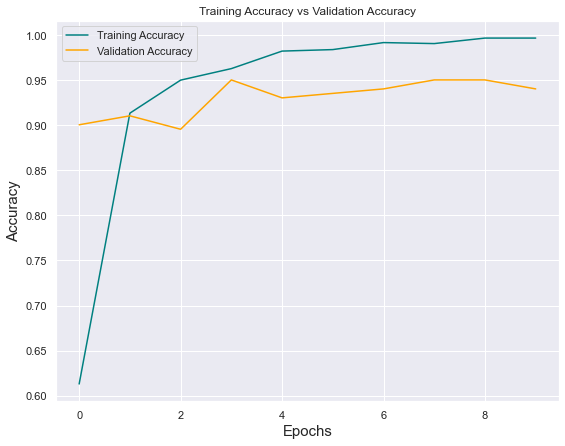

In [171]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.show()

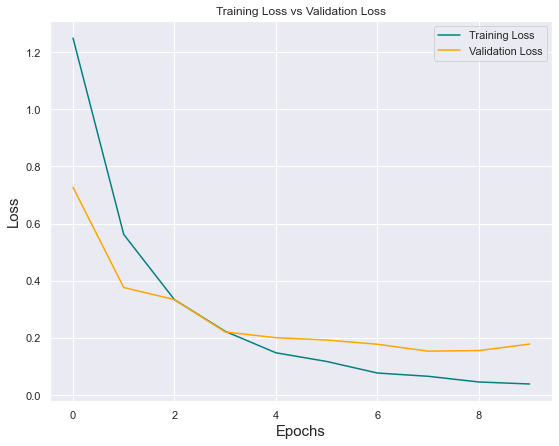

In [173]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

In [174]:
y_p = model1.predict(X_test)
y_pred = [np.argmax(i) for i in y_p]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        51
           1       0.95      0.90      0.92        39
           2       0.86      0.90      0.88        42
           3       0.93      1.00      0.96        51
           4       0.95      0.95      0.95        40

    accuracy                           0.94       223
   macro avg       0.94      0.93      0.94       223
weighted avg       0.94      0.94      0.94       223



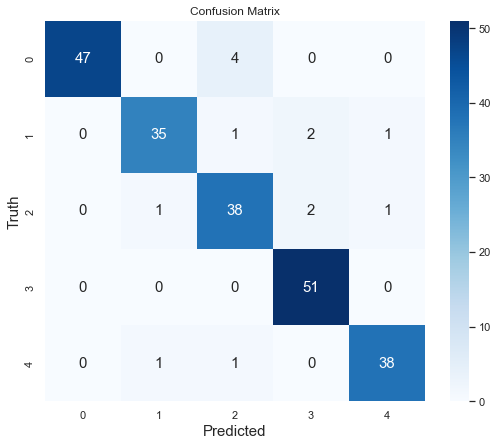

In [178]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Truth', fontsize = 15)
plt.show()